In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from src.models import CifarResNet, MNIST_CNN, CIFAR_CNN
from src.helpers import evaluate_rob_accuracy, evaluate_clean_accuracy, load_model, safe_model,_evaluate_model
from src.data_loader import load_torchvision_dataset, load_imagenette
#from src.pruning import identify_layers, _evaluate_sparsity

import time

if torch.cuda.is_available() == True:
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
print(device)
dtype = torch.float32

cuda:0


In [97]:
model = CifarResNet()
model.to(device)
train_loader, test_loader = load_torchvision_dataset('CIFAR10', data_augmentation=True)

identifying layers
Files already downloaded and verified
Files already downloaded and verified


In [125]:
train_stats = model.fit_fast_with_double_update(train_loader, test_loader, 200, device, patience=10)

[1,     1] loss: 43.28379, train_accuracy: 12.30


KeyboardInterrupt: 

In [8]:
train_stats.plot(x='epoch', y=['l_inf_robustness', 'l_2_robustness'])

TypeError: no numeric data to plot

In [9]:
#PATH='./saved-models/fast-double-vs-standard-experiment-double-update-fast-training.pt'
#optimizer = train_stats['optimizer'][0]
#safe_model(PATH, model, optimizer, description='Comparing fast adversarial training with single and double updates', loss='N/A',epoch='92')

'./saved-models/fast-double-vs-standard-experiment-double-update-fast-training.pt'

In [122]:
PATH='./saved-models/fast-double-vs-standard-experiment-double-update-fast-training.pt'
model = CifarResNet().to(device)
model = load_model(model, PATH)

identifying layers


In [32]:
def FGSM(model, data_loader, criterion, eps, device):
    #mean, std = (0.485, 0.456, 0.406), (0.229, 0.224, 0.225)
    #mean = torch.tensor(mean).view(3,1,1).expand(3,32,32).to(device)
    #std = torch.tensor(std).view(3,1,1).expand(3,32,32).to(device)
    advs = []
    correct = 0
    total = 0
    for data in data_loader:
        inputs, labels = data
        inputs, labels =inputs.to(device), labels.to(device)
        inputs.requires_grad = True
        perturbation = torch.zeros_like(inputs, requires_grad=True).to(device)
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        perturbation = torch.sign(inputs.grad).clamp_(-eps, eps)
        adv_examples = inputs + perturbation
        advs.append(adv_examples)
        preds = model(adv_examples)
        #pred_labels = 
        _, predicted = torch.max(preds.data, 1)
        total += len(predicted)
        #correct += (pred_labels == labels).sum().item()
        correct += (predicted != labels).sum().item()

    
    return advs, correct/total
        
        
        
        

In [37]:
advs, success = FGSM(model, test_loader, torch.nn.CrossEntropyLoss(), 16/255, device)

In [36]:
success

0.4104

In [38]:
success

0.4669

In [55]:
evaluate_clean_accuracy(model, test_loader, device)

(86.72, 0.0)

In [135]:
img = next(iter(test_loader))[0][1]
label = next(iter(test_loader))[1][1]

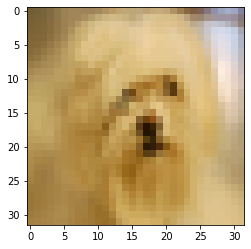

In [138]:
plt.imshow(img.permute(1, 2, 0)  )


In [116]:
import matplotlib.pyplot as plt

In [96]:
def load_torchvision_dataset(dataset, batchsize=512, data_augmentation=False):
    if data_augmentation == True:
        train_transforms = torchvision.transforms.Compose([
            #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
            torchvision.transforms.RandomHorizontalFlip(),
            torchvision.transforms.RandomRotation(20),
            torchvision.transforms.Resize(40),
            torchvision.transforms.RandomResizedCrop(32),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),        
        ])
    if data_augmentation == False:
        train_transforms = torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),        
        ])
    val_transforms = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ])
    
    if dataset == 'MNIST':
        train = torchvision.datasets.MNIST('./data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
        test = torchvision.datasets.MNIST('./data', train=False, transform=torchvision.transforms.ToTensor(), download=True)
    if dataset == 'CIFAR10':
        train = torchvision.datasets.CIFAR10('./data', train=True, transform=train_transforms, download=True)
        test = torchvision.datasets.CIFAR10('./data', train=False, transform=val_transforms, download=True)
    train_loader = torch.utils.data.DataLoader(
        train,
        batch_size=batchsize,
        shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        test,
        batch_size=batchsize,
        shuffle=True,
    )
    return train_loader, test_loader

In [137]:
img = invTrans(img)